In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from train_util import get_autoencoder, get_vae, get_gan
from train_util import program_map, one_hot_map
from keras import backend as K
import time

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 32000
sample_duration = 2 * sample_rate
n_fft = 2048
epsilon = 0.00001
batch_size = 4
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
instr_id = 0
note_id = 0
instrument = pm.instruments[instr_id]
print(instrument.notes[note_id])
note = instrument.notes[note_id]
sample_start = int(note.start * sample_rate)

Note(start=51.199068, end=51.318113, pitch=81, velocity=105)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(10043769,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(64000,)
-0.05516061084781464


(1025, 126)
(0.01231394+0j)


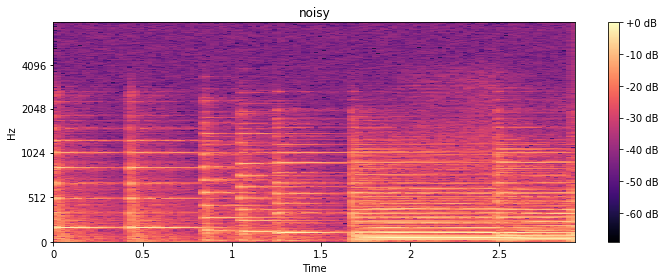

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(1025, 126, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch
annotation[0,0,1] = note.end - note.start
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 126, 2)
(1026, 126, 2)


In [10]:
velocity = 96
pitch = 60
duration = 1
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=False)
iso_note = pretty_midi.Note(velocity, pitch, 0, duration)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                            'constant', constant_values=(0,0))

ipd.Audio(pm_iso_samples, rate=sample_rate)

(1025, 126)


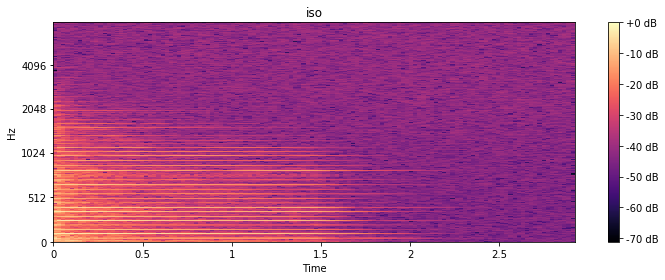

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

In [12]:
# convert complex numbers to magnitude and phase
magnitude = np.abs(iso_stft)
phase = np.angle(iso_stft)
log_magnitude = np.log(magnitude)
largest_magnitude = max(np.abs(np.amin(log_magnitude)), np.amax(log_magnitude))
magnitude_scale_factor = largest_magnitude * 1.25  # will scale range to [-0.8, 0.8]
scaled_magnitude = log_magnitude / magnitude_scale_factor
print("mag scale factor {}".format(magnitude_scale_factor))
scaled_phase = phase / (np.pi + epsilon)

print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))
print("mag scaled [{}, {}]".format(np.amin(scaled_magnitude), np.amax(scaled_magnitude)))
print("phase unscaled [{}, {}]".format(np.amin(phase), np.amax(phase)))
print("phase scaled [{}, {}]".format(np.amin(scaled_phase), np.amax(scaled_phase)))

final_iso = np.stack((magnitude, phase), axis=2)
print(final_iso.shape)

rev_magnitude = np.exp(scaled_magnitude * magnitude_scale_factor)
assert np.allclose(magnitude, rev_magnitude)
rev_phase = scaled_phase * (np.pi + epsilon)
assert np.allclose(phase, rev_phase)

rev_iso = magnitude * np.exp(1j*phase)
assert iso_stft.shape == rev_iso.shape
assert np.allclose(iso_stft, rev_iso)

final_iso = final_iso[:-1, :, :]  # shape (1024, 126, 2)
print(final_iso.shape)
final_iso_pad = np.zeros((1024, 2, 2))
final_iso = np.concatenate((final_iso, final_iso_pad), axis=1)  # shape (1024, 128, 2)
print(final_iso.shape)

mag scale factor 14.262492656707764
mag unscaled [1.1084148354711942e-05, 143.81735229492188]
mag scaled [-0.7999999523162842, 0.34836435317993164]
phase unscaled [-3.1415927410125732, 3.1415927410125732]
phase scaled [-0.9999968409538269, 0.9999968409538269]
(1025, 126, 2)
(1024, 126, 2)
(1024, 128, 2)


In [20]:
print("loading model")
model_type = 'vae'

if model_type == 'ae':
    encoder = keras.models.load_model('ae/encoder-0.h')
    decoder = keras.models.load_model('ae/decoder-0.h')
    autoencoder = keras.models.load_model('ae/ae-0.h')
elif model_type == 'vae':
    _, _, _, my_vae_loss = get_vae()
    encoder = keras.models.load_model('vae/encoder-0.h')
    decoder = keras.models.load_model('vae/decoder-0.h')
    autoencoder = keras.models.load_model('vae/vae-0.h', custom_objects={'my_vae_loss': my_vae_loss})
elif model_type == 'gan':
    encoder = keras.models.load_model('gan/encoder-0.h')
    decoder = keras.models.load_model('gan/decoder-0.h')
    autoencoder = keras.models.load_model('gan/encoder-0.h')
else:
    assert False

loading model


In [21]:
instr_indices = [0]
note_indices = [0]
song_indices = [0]
test_generator = NoteIsoSequence([midi_file], sample_duration=sample_duration, 
                                 fs=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                 note_indices=note_indices, song_indices=song_indices, batch_size=1)

In [25]:
predicted_encode = encoder.predict_generator(test_generator, steps=1)
print(len(predicted_encode))
print(predicted_encode.shape)
predicted_decode = decoder.predict(predicted_encode)
print(predicted_decode.shape)
predicted_ae = autoencoder.predict_generator(test_generator, steps=1)
print(predicted_ae.shape)
assert np.all(predicted_decode == predicted_ae)

3


AttributeError: 'list' object has no attribute 'shape'